# Purpose

The purpose of this notebook is to house code and figures for aggregate properties the street/metro multiplex. These are properties that we can learn only from the multiplex and flows assigned on it, in contrast to properties (like path length distributions) that can be learned only via route-wise analysis. 

In [18]:
import matplotlib
matplotlib.use('Agg')
% matplotlib inline 

from metro import multiplex as mx
from metro import assignment
from metro import utility
from metro import ita
from metro import viz

import pandas as pd
import numpy as np
import cProfile
import time
import networkx as nx
import matplotlib.pyplot as plt # convenience for plotting
from matplotlib import pylab
pylab.rcParams['savefig.facecolor'] = 'black'
pylab.rcParams['savefig.dpi'] = 72 # should be ~300 for final figs

/home/pchodrow/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Read the multiplex

In [19]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

In [20]:
multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [21]:
multi.summary()

OD: loaded

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
taz              	4243 	0
streets          	10728 	21508
taz--streets     	0 	8486
metro            	117 	250


In [22]:
G = multi.layers_as_subgraph(['streets'])

In [23]:
def edge_wise_cor(multi, attr1, attr2, weight):
    df = multi.edges_2_df(['streets'], [attr1, attr2, weight])
    for attr in [attr1, attr2]:
        df[attr + '_weighted'] = df[attr] * df[weight] 
    df = df.dropna(thresh = 5)
    return np.corrcoef(df[attr1 + '_weighted'], df[attr2 + '_weighted'])[0][1]

In [24]:
betas = [100, 1, 0.9, 0.8, 0.7, 0.6, .5, .4, .3, .2, .1, .01]

for beta in betas:
    print beta, edge_wise_cor(multi, 'flow_100', 'flow_' + str(beta), 'dist_km')
    

100 nan
1 0.99901621155
0.9 0.9980228867
0.8 0.994900245055
0.7 0.988751092122
0.6 0.97543441197
0.5 0.937914584179
0.4 0.843667938522
0.3 0.726787346438
0.2 0.631219874904
0.1 0.547316152903
0.01 0.487302568288


In [ ]:
def od_total(od):
    return np.sum(np.sum(od[o].values()) for o in od)


In [25]:
def metro_flow(beta): 
    flow = 'flow_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'dist_km'])
    df['weighted_flow'] = df[flow] * df['dist_km']
    sums = df.groupby('layer').sum()['weighted_flow']
    metro, streets = (sums['metro'], sums['streets'])
    return 1.0 * metro / (metro + streets)

## Flowmaps as functions of $\beta$. 

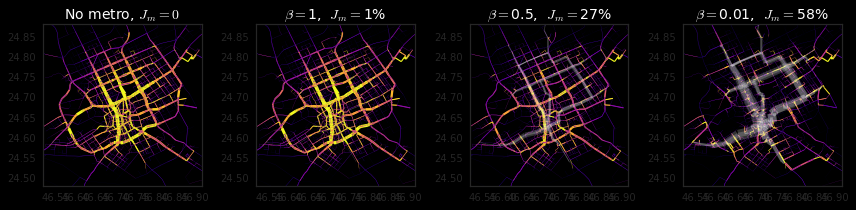

In [26]:
reload(viz)
cmap = 'plasma'

center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

betas = [100, 1, .5, .01]

fig = plt.figure(dpi = 500, figsize = (3 * len(betas),3))

i = 0
for i in range(len(betas)):
    J_m = metro_flow(betas[i])
    ax = fig.add_subplot(1, len(betas), i+1)
    if betas[i] == 100:
        title_str = r'No metro, $J_m = 0$' 
    else:
        title_str = r'$\beta = $' + str(betas[i]) + r',  $J_m = $' + str(int(100 * J_m)) + '%'
    
    plt.title(title_str, 
              color = 'w', 
              fontsize = 14)
    
    ax.set(xlim = xlim, ylim = ylim)
    viz.flow_plot(multi, 'flow_' + str(betas[i]), ax, background = False)
    
fig.set_facecolor("#000000")
plt.tight_layout()
plt.savefig('4_figs/flow_map.png')

## Aggregate flow through metro

In [27]:
import seaborn as sns
sns.set_style("white")
pylab.rcParams['savefig.facecolor'] = 'white'

In [28]:
betas = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01]

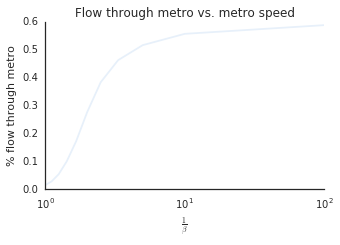

In [29]:
def metro_flow(beta): 
    flow = 'flow_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'dist_km'])
    df['weighted_flow'] = df[flow] * df['dist_km']
    sums = df.groupby('layer').sum()['weighted_flow']
    metro, streets = (sums['metro'], sums['streets'])
    return 1.0 * metro / (metro + streets)

fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)

y = [metro_flow(beta) for beta in betas]
x = [1.0/beta for beta in betas]
ax.semilogx(x,y)
ax.set(ylim = (0, None), 
       xlabel = r'$\frac{1}{\beta}$', 
       ylabel = '% flow through metro',
       title = 'Flow through metro vs. metro speed')

sns.despine()
plt.savefig('4_figs/flow_thru_metro.png')


# Time spent, lost to congestion

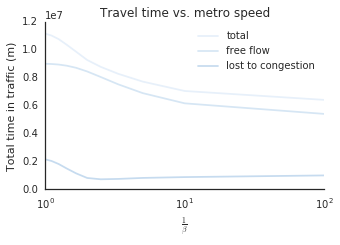

In [30]:
def time_lost(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', cong_time])
    df['time_lost'] = df[flow]* (df[cong_time] - df['free_flow_time_m'])
    df = df[df.layer == 'streets']
    return df.sum()['time_lost']

def time_free(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', cong_time])
    df['time_free'] = df[flow] * df['free_flow_time_m']

    streets_part = df[df.layer == 'streets'].sum()['time_free']
    
    df['time_free'] = df[flow] * df[cong_time]
    metro_part = df[df.layer == 'metro'].sum()['time_free']
    return streets_part + metro_part

def time_spent(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow,  cong_time])
    df['time_spent'] = df[flow]*df[cong_time]
    return df.sum()['time_spent']

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)
betas = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01]
x = [1.0/beta for beta in betas]

labs = ['total', 'free flow', 'lost to congestion']
funs = [time_spent, time_free, time_lost]

for i in range(3):
    y = [funs[i](beta) for beta in betas]
    ax.semilogx(x,y, label = labs[i])

ax.set(ylim = (0, None), 
       xlabel = r'$\frac{1}{\beta}$', 
       ylabel = 'Total time in traffic (m)',
       title = 'Travel time vs. metro speed')

ax.legend(loc = 1)
sns.despine()
plt.savefig('4_figs/time_decomp.png', pad_inches=0.0)

In [40]:
def od_total(od):
    return np.sum(np.sum(od[o].values()) for o in od)

for beta in [str(100)] + betas:
    print beta, time_spent(beta) / od_total(multi.od) * 4, time_lost(beta) / od_total(multi.od) * 4

 100 19.3622437966 3.94934941639
1 19.0628436101 3.68419144127
0.9 18.8272722544 3.47940813486
0.8 18.3884152755 3.10746298585
0.7 17.6961447922 2.55658577602
0.6 16.8495233868 1.96622628252
0.5 15.8370603158 1.4028220052
0.4 15.0012750151 1.24246189863
0.3 14.1515585617 1.28570915068
0.2 13.1956755147 1.40917029203
0.1 12.0462206091 1.51053655913
0.01 10.9576069085 1.71482861669


In [31]:
time_spent(0.01) / time_spent(100) 

0.5659265023031961

In [32]:
for beta in betas:
    print beta, time_lost(beta)

1 2158328.79036
0.9 2038359.5344
0.8 1820460.99782
0.7 1497737.77324
0.6 1151884.43966
0.5 821822.418799
0.4 727877.834116
0.3 753213.593862
0.2 825541.468269
0.1 884925.389043
0.01 1004606.85416


## Total distance traveled

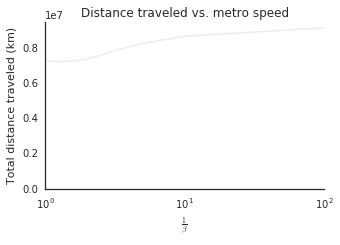

In [33]:
def distance_travelled(beta):
    flow = 'flow_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', 'dist_km'])
    df['distance_travelled'] = df[flow]*df.dist_km
    return df.sum()['distance_travelled']

x = [1.0/beta for beta in betas]
y = [distance_travelled(beta) for beta in betas]

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)
ax.semilogx(x,y)

ax.set(ylim = (0, None), 
       xlabel = r'$\frac{1}{\beta}$', 
       ylabel = 'Total distance traveled (km)',
       title = 'Distance traveled vs. metro speed')
sns.despine()
plt.savefig('4_figs/distance_traveled.png')

## Betweenness distributions

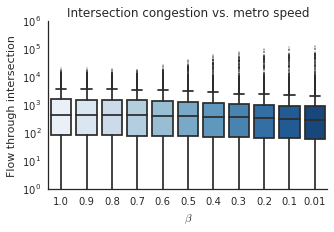

In [34]:
sns.set_palette(sns.color_palette("Blues", len(betas)))
G = multi.layers_as_subgraph(multi.get_layers())

def get_betweenness(beta):
    flow = 'flow_' + str(beta)
    return np.array([np.sum([G.edge[e[0]][e[1]][flow] 
                             for e in G.in_edges(n)]) 
                     for n in G.node])

df = pd.DataFrame({beta : get_betweenness(beta) for beta in betas})

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

flierprops = dict(marker='o', markersize=1)
sns.boxplot(df, order = np.array(betas[::]), ax = ax, flierprops = flierprops)

ax.set_yscale('log')
ax.set(xlabel = r'$\beta$', 
       ylabel = 'Flow through intersection',
       ylim = (1, None),
       title = 'Intersection congestion vs. metro speed')

sns.despine()
plt.savefig('4_figs/betweenness.png')